In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
import os
from pathlib import Path

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import random
# Utilities
import warnings
warnings.filterwarnings('ignore')
import time
from tqdm import tqdm
import joblib

# Set random seeds for reproducibility
np.random.seed(7)
tf.random.set_seed(7)

print("✅ All libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")


2025-08-08 13:37:29.539683: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754660249.732159      18 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754660249.789115      18 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


✅ All libraries imported successfully!
TensorFlow version: 2.18.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [2]:
BASE_PATH = '/kaggle/input/real-life-industrial-dataset-of-casting-product'

# Update these paths based on your dataset structure
TRAIN_PATH = os.path.join(BASE_PATH, 'casting_data/casting_data/train')
TEST_PATH = os.path.join(BASE_PATH, 'casting_data/casting_data/test')

# Alternative paths if the structure is different
if not os.path.exists(TRAIN_PATH):
    TRAIN_PATH = os.path.join(BASE_PATH, 'casting_512x512/casting_512x512/train')
    TEST_PATH = os.path.join(BASE_PATH, 'casting_512x512/casting_512x512/test')

# Image configuration
IMG_HEIGHT = 224  # Resize to 224x224 for transfer learning models
IMG_WIDTH = 224
BATCH_SIZE = 32
EPOCHS = 30

print("\n📁 Dataset Paths:")
print(f"Base Path: {BASE_PATH}")
print(f"Train Path: {TRAIN_PATH}")
print(f"Test Path: {TEST_PATH}")


📁 Dataset Paths:
Base Path: /kaggle/input/real-life-industrial-dataset-of-casting-product
Train Path: /kaggle/input/real-life-industrial-dataset-of-casting-product/casting_data/casting_data/train
Test Path: /kaggle/input/real-life-industrial-dataset-of-casting-product/casting_data/casting_data/test


In [3]:
if os.path.exists(TRAIN_PATH):
    print("✅ Training path exists")
    train_defective = os.path.join(TRAIN_PATH, 'def_front')
    train_ok = os.path.join(TRAIN_PATH, 'ok_front')
    print(f"  - Defective samples: {len(os.listdir(train_defective)) if os.path.exists(train_defective) else 0}")
    print(f"  - OK samples: {len(os.listdir(train_ok)) if os.path.exists(train_ok) else 0}")
else:
    print("❌ Training path not found. Please check the dataset structure.")

if os.path.exists(TEST_PATH):
    print("✅ Test path exists")
    test_defective = os.path.join(TEST_PATH, 'def_front')
    test_ok = os.path.join(TEST_PATH, 'ok_front')
    print(f"  - Defective samples: {len(os.listdir(test_defective)) if os.path.exists(test_defective) else 0}")
    print(f"  - OK samples: {len(os.listdir(test_ok)) if os.path.exists(test_ok) else 0}")
else:
    print("❌ Test path not found. Please check the dataset structure.")

✅ Training path exists
  - Defective samples: 3758
  - OK samples: 2875
✅ Test path exists
  - Defective samples: 453
  - OK samples: 262



📊 DATASET EXPLORATION

📈 Dataset Summary:
Class    Defective    OK
Dataset                 
Test           453   262
Train         3758  2875

Total Training Images: 6633
Total Test Images: 715
Total Images: 7348


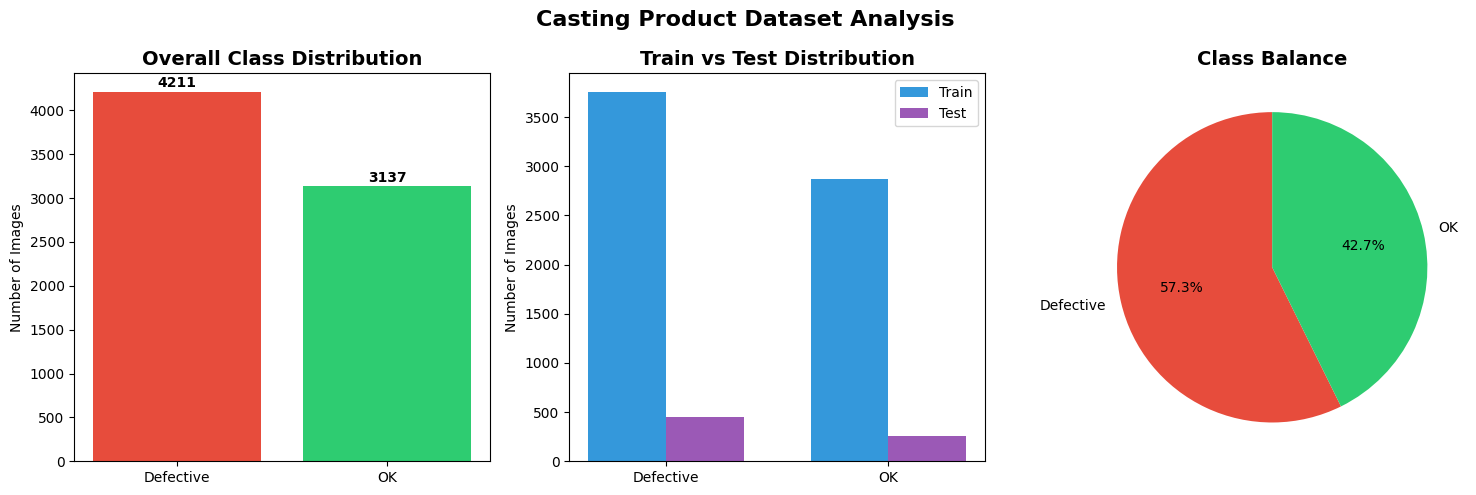

In [4]:
def explore_dataset():
    """
    Explore and visualize the casting dataset
    """
    print("\n" + "="*80)
    print("📊 DATASET EXPLORATION")
    print("="*80)
    
    # Count images in each category
    train_def_count = len(os.listdir(os.path.join(TRAIN_PATH, 'def_front')))
    train_ok_count = len(os.listdir(os.path.join(TRAIN_PATH, 'ok_front')))
    test_def_count = len(os.listdir(os.path.join(TEST_PATH, 'def_front')))
    test_ok_count = len(os.listdir(os.path.join(TEST_PATH, 'ok_front')))
    
    # Create summary dataframe
    summary_data = {
        'Dataset': ['Train', 'Train', 'Test', 'Test'],
        'Class': ['Defective', 'OK', 'Defective', 'OK'],
        'Count': [train_def_count, train_ok_count, test_def_count, test_ok_count]
    }
    summary_df = pd.DataFrame(summary_data)
    
    print("\n📈 Dataset Summary:")
    print(summary_df.pivot(index='Dataset', columns='Class', values='Count'))
    print(f"\nTotal Training Images: {train_def_count + train_ok_count}")
    print(f"Total Test Images: {test_def_count + test_ok_count}")
    print(f"Total Images: {train_def_count + train_ok_count + test_def_count + test_ok_count}")
    
    # Visualize distribution
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Overall distribution
    total_def = train_def_count + test_def_count
    total_ok = train_ok_count + test_ok_count
    axes[0].bar(['Defective', 'OK'], [total_def, total_ok], color=['#e74c3c', '#2ecc71'])
    axes[0].set_title('Overall Class Distribution', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Number of Images')
    for i, v in enumerate([total_def, total_ok]):
        axes[0].text(i, v + 50, str(v), ha='center', fontweight='bold')
    
    # Train vs Test distribution
    x = np.arange(2)
    width = 0.35
    axes[1].bar(x - width/2, [train_def_count, train_ok_count], width, label='Train', color='#3498db')
    axes[1].bar(x + width/2, [test_def_count, test_ok_count], width, label='Test', color='#9b59b6')
    axes[1].set_title('Train vs Test Distribution', fontsize=14, fontweight='bold')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(['Defective', 'OK'])
    axes[1].set_ylabel('Number of Images')
    axes[1].legend()
    
    # Class balance pie chart
    axes[2].pie([total_def, total_ok], labels=['Defective', 'OK'], 
                autopct='%1.1f%%', colors=['#e74c3c', '#2ecc71'],
                startangle=90)
    axes[2].set_title('Class Balance', fontsize=14, fontweight='bold')
    
    plt.suptitle('Casting Product Dataset Analysis', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return summary_df

# Explore the dataset
summary = explore_dataset()


🖼️ SAMPLE IMAGES VISUALIZATION


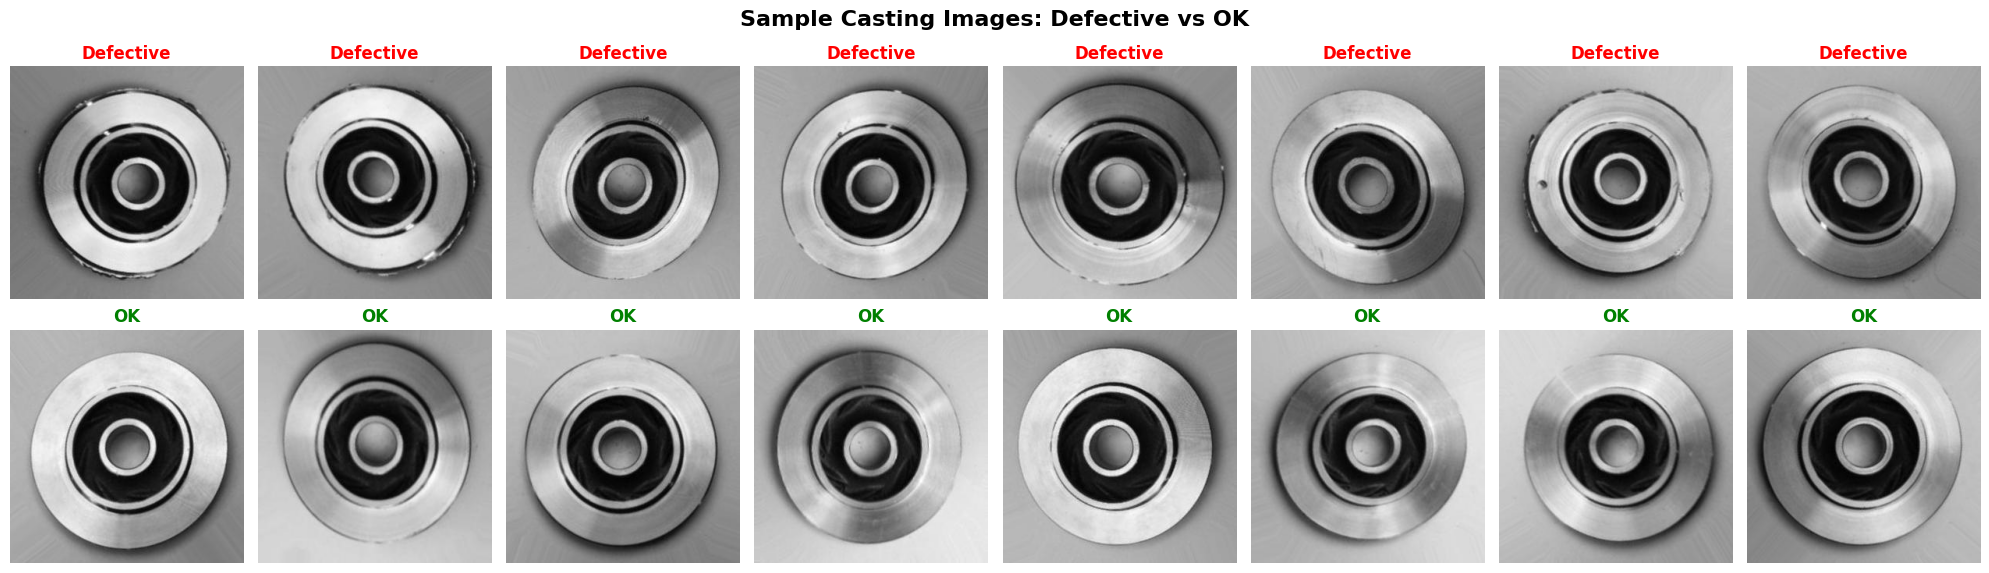

In [5]:
def visualize_samples(num_samples=8):
    """
    Visualize sample images from both classes
    """
    print("\n" + "="*80)
    print("🖼️ SAMPLE IMAGES VISUALIZATION")
    print("="*80)
    
    fig, axes = plt.subplots(2, num_samples, figsize=(20, 6))
    
    # Get sample defective images
    def_path = os.path.join(TRAIN_PATH, 'def_front')
    def_images = random.sample(os.listdir(def_path), min(num_samples, len(os.listdir(def_path))))
    
    # Get sample OK images
    ok_path = os.path.join(TRAIN_PATH, 'ok_front')
    ok_images = random.sample(os.listdir(ok_path), min(num_samples, len(os.listdir(ok_path))))
    
    # Display defective images
    for idx, img_name in enumerate(def_images):
        img_path = os.path.join(def_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[0, idx].imshow(img)
        axes[0, idx].set_title('Defective', color='red', fontweight='bold')
        axes[0, idx].axis('off')
    
    # Display OK images
    for idx, img_name in enumerate(ok_images):
        img_path = os.path.join(ok_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[1, idx].imshow(img)
        axes[1, idx].set_title('OK', color='green', fontweight='bold')
        axes[1, idx].axis('off')
    
    plt.suptitle('Sample Casting Images: Defective vs OK', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Visualize samples
visualize_samples()

In [6]:
print("\n" + "="*80)
print("🔄 DATA PREPROCESSING")
print("="*80)

# Create data generators with augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest',
    validation_split=0.2  # Use 20% of training data for validation
)

# Only rescaling for test data (no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create training generator
train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',  # Binary classification (defective vs ok)
    subset='training',
    seed=42
)

# Create validation generator
validation_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    seed=7
)

# Create test generator
test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

print(f"\n✅ Data Generators Created:")
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")
print(f"Class mapping: {train_generator.class_indices}")


🔄 DATA PREPROCESSING
Found 5307 images belonging to 2 classes.
Found 1326 images belonging to 2 classes.
Found 715 images belonging to 2 classes.

✅ Data Generators Created:
Training samples: 5307
Validation samples: 1326
Test samples: 715
Class mapping: {'def_front': 0, 'ok_front': 1}


In [7]:
def create_custom_cnn():
    """
    Create a custom CNN model for defect detection
    """
    model = models.Sequential([
        # Block 1
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Block 2
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Block 3
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Block 4
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Fully Connected Layers
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')  # Binary classification
    ])
    
    return model

def create_transfer_learning_model(base_model_name='VGG16'):
    """
    Create a transfer learning model
    """
    # Select base model
    if base_model_name == 'VGG16':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    elif base_model_name == 'ResNet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    else:  # MobileNetV2
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    
    # Freeze base model layers
    base_model.trainable = False
    
    # Create new model
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    
    return model

print("\n" + "="*80)
print("🧠 BUILDING DEEP LEARNING MODELS")
print("="*80)



🧠 BUILDING DEEP LEARNING MODELS


In [8]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
custom_cnn = create_custom_cnn()
vgg16_model = create_transfer_learning_model('VGG16')
mobilenet_model = create_transfer_learning_model('MobileNetV2')

# Compile models
models_dict = {
    'Custom CNN': custom_cnn,
    'VGG16 Transfer': vgg16_model,
    'MobileNetV2 Transfer': mobilenet_model
}

for name, model in models_dict.items():
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )
    print(f"\n{name} Model:")
    print(f"Total parameters: {model.count_params():,}")
    print(f"Trainable parameters: {sum([tf.size(w).numpy() for w in model.trainable_weights]):,}")


I0000 00:00:1754660271.437456      18 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1754660271.438145      18 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Custom CNN Model:
Total parameters: 19,333,569
Trainable parameters: 19,331,329

VGG16 Transfer Model:
Total parameters: 14,880,577
Trainable parameters: 165,121

MobileNetV2 Transfer Model:
Total parameters: 2,620,481
Trainable parameters: 361,729


In [9]:
def train_model(model, model_name, epochs=EPOCHS):
    """
    Train a deep learning model with callbacks
    """
    print(f"\n🚀 Training {model_name}...")
    
    # Define callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )
    
    model_checkpoint = ModelCheckpoint(
        f'{model_name}_best.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
    
    # Train the model
    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=validation_generator,
        callbacks=[early_stopping, model_checkpoint, reduce_lr],
        verbose=1
    )
    
    return history

# Train the best model (MobileNetV2 for efficiency on Kaggle)
print("\n" + "="*80)
print("🎯 TRAINING SELECTED MODEL")
print("="*80)


🎯 TRAINING SELECTED MODEL


In [10]:
selected_model = mobilenet_model
selected_model_name = 'MobileNetV2_Transfer'

history = train_model(selected_model, selected_model_name, epochs=20)


🚀 Training MobileNetV2_Transfer...
Epoch 1/20


I0000 00:00:1754660285.438606      85 service.cc:148] XLA service 0x785710010d30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754660285.439456      85 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1754660285.439477      85 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1754660286.656253      85 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/166 ━━━━━━━━━━━━━━━━━━━━ 43:48 16s/step - accuracy: 0.5000 - loss: 1.3222 - precision_2: 0.2941 - recall_2: 0.5556

I0000 00:00:1754660291.966787      85 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - accuracy: 0.8318 - loss: 0.3996 - precision_2: 0.7763 - recall_2: 0.8666
Epoch 1: val_accuracy improved from -inf to 0.94646, saving model to MobileNetV2_Transfer_best.h5
166/166 ━━━━━━━━━━━━━━━━━━━━ 131s 698ms/step - accuracy: 0.8322 - loss: 0.3988 - precision_2: 0.7767 - recall_2: 0.8668 - val_accuracy: 0.9465 - val_loss: 0.1476 - val_precision_2: 0.9038 - val_recall_2: 0.9809 - learning_rate: 0.0010
Epoch 2/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.9418 - loss: 0.1521 - precision_2: 0.9259 - recall_2: 0.9383
Epoch 2: val_accuracy improved from 0.94646 to 0.97360, saving model to MobileNetV2_Transfer_best.h5
166/166 ━━━━━━━━━━━━━━━━━━━━ 76s 458ms/step - accuracy: 0.9418 - loss: 0.1521 - precision_2: 0.9260 - recall_2: 0.9384 - val_accuracy: 0.9736 - val_loss: 0.0841 - val_precision_2: 0.9608 - val_recall_2: 0.9791 - learning_rate: 0.0010
Epoch 3/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.9544 - loss: 0.13

In [11]:
# PART 8: EVALUATE MODEL PERFORMANCE
# ============================================================================

def evaluate_model(model, history, model_name):
    """
    Comprehensive model evaluation
    """
    print("\n" + "="*80)
    print("📊 MODEL EVALUATION")
    print("="*80)
    
    # Plot training history
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Accuracy plot
    axes[0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    axes[0].set_title(f'{model_name} - Accuracy', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Loss plot
    axes[1].plot(history.history['loss'], label='Training Loss', linewidth=2)
    axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    axes[1].set_title(f'{model_name} - Loss', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    print("\n📈 Test Set Evaluation:")
    test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_generator, verbose=0)
    
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall: {test_recall:.4f}")
    print(f"Test F1-Score: {2 * (test_precision * test_recall) / (test_precision + test_recall):.4f}")
    
    # Get predictions
    predictions = model.predict(test_generator)
    predicted_classes = (predictions > 0.5).astype(int).flatten()
    true_classes = test_generator.classes
    
    # Confusion Matrix
    cm = confusion_matrix(true_classes, predicted_classes)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['OK', 'Defective'],
                yticklabels=['OK', 'Defective'])
    plt.title(f'Confusion Matrix', fontsize=14, fontweight='bold')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    print("\n📋 Detailed Classification Report:")
    print(classification_report(true_classes, predicted_classes, 
                              target_names=['OK', 'Defective']))
    
    # ROC Curve
    fpr, tpr, thresholds = roc_curve(true_classes, predictions)
    roc_auc = roc_auc_score(true_classes, predictions)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return test_accuracy, predictions


📊 MODEL EVALUATION


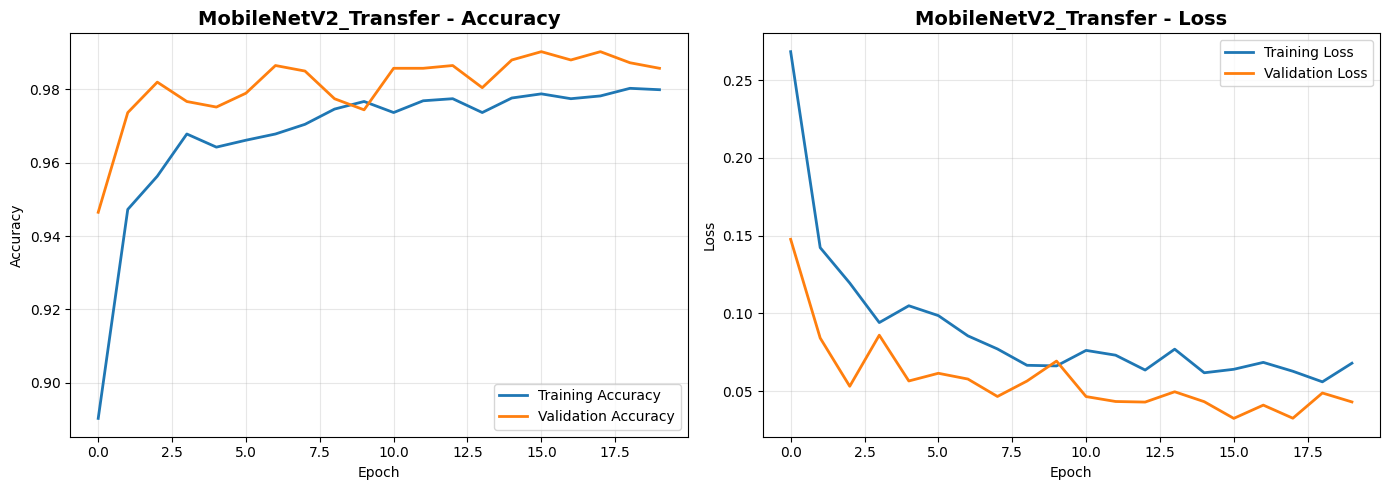


📈 Test Set Evaluation:
Test Loss: 0.0273
Test Accuracy: 0.9944
Test Precision: 0.9850
Test Recall: 1.0000
Test F1-Score: 0.9924
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 228ms/step


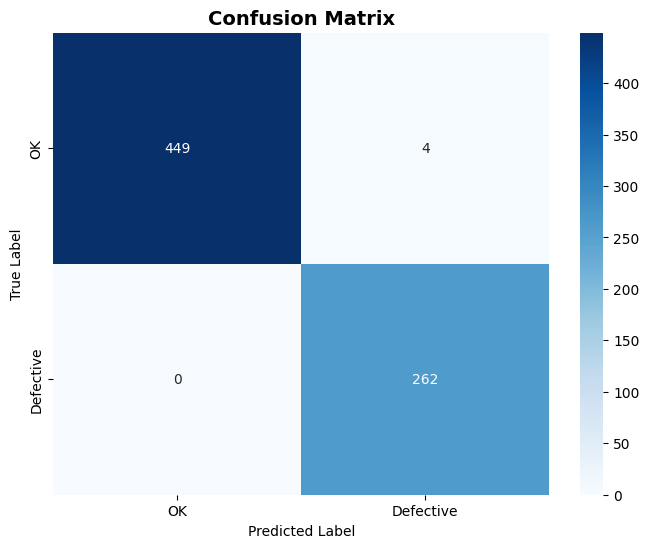


📋 Detailed Classification Report:
              precision    recall  f1-score   support

          OK       1.00      0.99      1.00       453
   Defective       0.98      1.00      0.99       262

    accuracy                           0.99       715
   macro avg       0.99      1.00      0.99       715
weighted avg       0.99      0.99      0.99       715



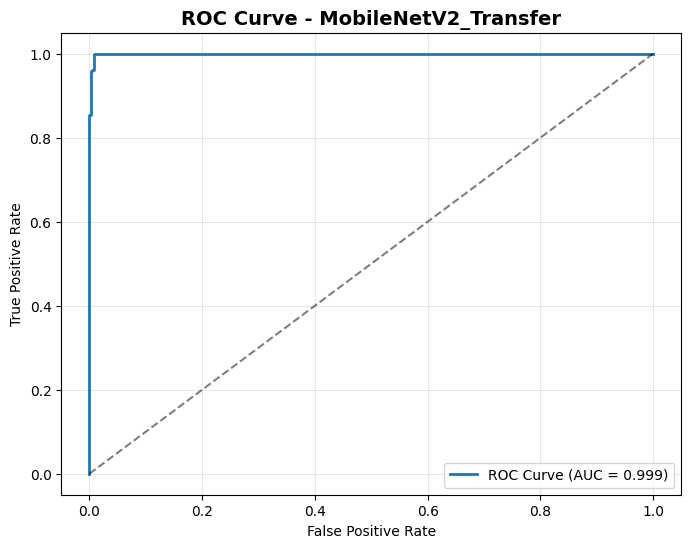

In [12]:
# Evaluate the model
test_acc, predictions = evaluate_model(selected_model, history, selected_model_name)


🔮 SAMPLE PREDICTIONS


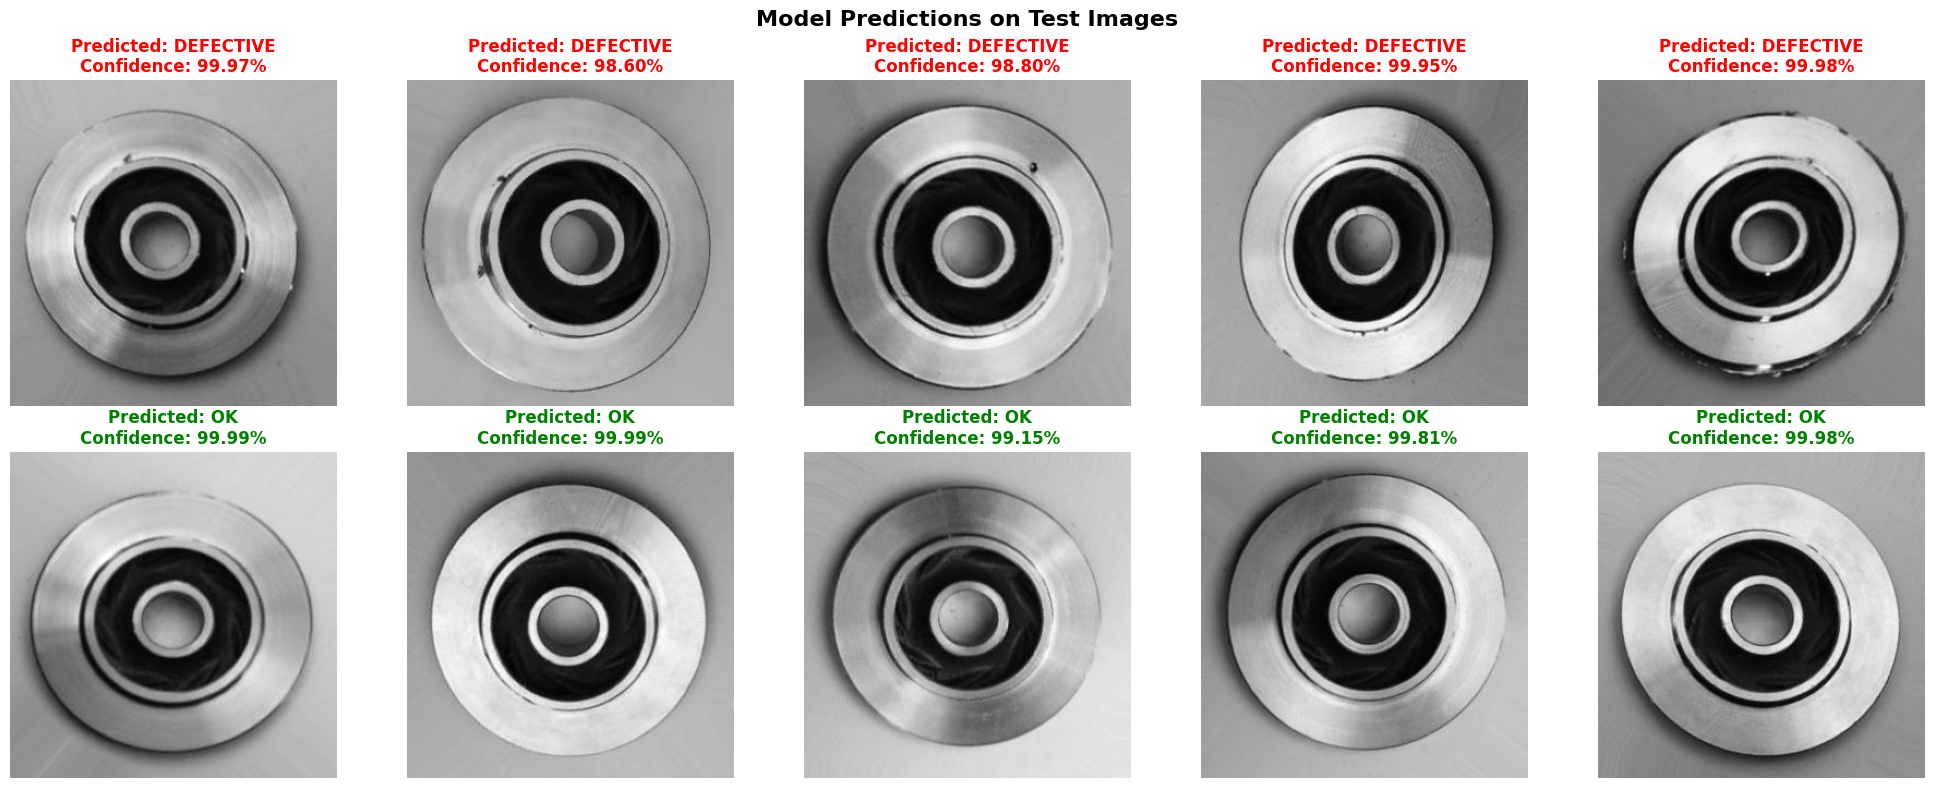

In [13]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
def predict_single_image(model, image_path):
    """
    Predict defect for a single image
    """
    # Load and preprocess image
    img = load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    
    # Make prediction
    prediction = model.predict(img_array, verbose=0)[0][0]
    
    # Determine class
    if prediction > 0.5:
        result = "OK"
        confidence = prediction # Confidence is the direct prediction score
        color = 'green'
    else:
        result = "DEFECTIVE"
        confidence = 1 - prediction # Confidence is how far it is from 1
        color = 'red'
    
    return result, confidence, color

def visualize_predictions(model, num_samples=10):
    """
    Visualize predictions on random test samples
    """
    print("\n" + "="*80)
    print("🔮 SAMPLE PREDICTIONS")
    print("="*80)
    
    # Get random test images
    test_def_path = os.path.join(TEST_PATH, 'def_front')
    test_ok_path = os.path.join(TEST_PATH, 'ok_front')
    
    def_images = random.sample(os.listdir(test_def_path), min(num_samples//2, len(os.listdir(test_def_path))))
    ok_images = random.sample(os.listdir(test_ok_path), min(num_samples//2, len(os.listdir(test_ok_path))))
    
    fig, axes = plt.subplots(2, num_samples//2, figsize=(20, 8))
    
    # Predict on defective images
    for idx, img_name in enumerate(def_images):
        img_path = os.path.join(test_def_path, img_name)
        result, confidence, color = predict_single_image(model, img_path)
        
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        axes[0, idx].imshow(img)
        axes[0, idx].set_title(f'Predicted: {result}\nConfidence: {confidence:.2%}', 
                              color=color, fontweight='bold')
        axes[0, idx].axis('off')
    
    # Predict on OK images
    for idx, img_name in enumerate(ok_images):
        img_path = os.path.join(test_ok_path, img_name)
        result, confidence, color = predict_single_image(model, img_path)
        
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        axes[1, idx].imshow(img)
        axes[1, idx].set_title(f'Predicted: {result}\nConfidence: {confidence:.2%}', 
                              color=color, fontweight='bold')
        axes[1, idx].axis('off')
    
    plt.suptitle('Model Predictions on Test Images', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
visualize_predictions(selected_model)


🔍 ERROR ANALYSIS
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step
Total Test Samples: 715
Correctly Classified: 711 (99.44%)
Misclassified: 4 (0.56%)

False Positives (OK predicted as Defective): 4
False Negatives (Defective predicted as OK): 0


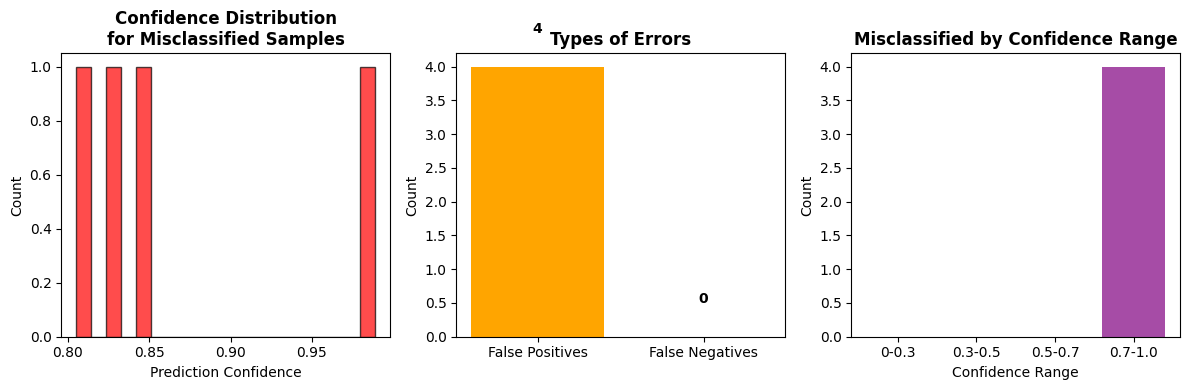

In [14]:
def error_analysis(model):
    """
    Analyze misclassified samples
    """
    print("\n" + "="*80)
    print("🔍 ERROR ANALYSIS")
    print("="*80)
    
    # Get all predictions
    predictions = model.predict(test_generator)
    predicted_classes = (predictions > 0.5).astype(int).flatten()
    true_classes = test_generator.classes
    
    # Find misclassified indices
    misclassified_indices = np.where(predicted_classes != true_classes)[0]
    correct_indices = np.where(predicted_classes == true_classes)[0]
    
    print(f"Total Test Samples: {len(true_classes)}")
    print(f"Correctly Classified: {len(correct_indices)} ({len(correct_indices)/len(true_classes)*100:.2f}%)")
    print(f"Misclassified: {len(misclassified_indices)} ({len(misclassified_indices)/len(true_classes)*100:.2f}%)")
    
    # Analyze false positives and false negatives
    false_positives = []
    false_negatives = []
    
    for idx in misclassified_indices:
        if true_classes[idx] == 0 and predicted_classes[idx] == 1:
            false_positives.append(idx)
        elif true_classes[idx] == 1 and predicted_classes[idx] == 0:
            false_negatives.append(idx)
    
    print(f"\nFalse Positives (OK predicted as Defective): {len(false_positives)}")
    print(f"False Negatives (Defective predicted as OK): {len(false_negatives)}")
    
    # Confidence distribution for misclassified samples
    misclassified_confidences = predictions[misclassified_indices].flatten()
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.hist(misclassified_confidences, bins=20, color='red', alpha=0.7, edgecolor='black')
    plt.title('Confidence Distribution\nfor Misclassified Samples', fontweight='bold')
    plt.xlabel('Prediction Confidence')
    plt.ylabel('Count')
    
    plt.subplot(1, 3, 2)
    categories = ['False Positives', 'False Negatives']
    counts = [len(false_positives), len(false_negatives)]
    colors = ['orange', 'red']
    plt.bar(categories, counts, color=colors)
    plt.title('Types of Errors', fontweight='bold')
    plt.ylabel('Count')
    for i, v in enumerate(counts):
        plt.text(i, v + 0.5, str(v), ha='center', fontweight='bold')
    
    plt.subplot(1, 3, 3)
    confidence_ranges = ['0-0.3', '0.3-0.5', '0.5-0.7', '0.7-1.0']
    range_counts = [
        np.sum((misclassified_confidences >= 0) & (misclassified_confidences < 0.3)),
        np.sum((misclassified_confidences >= 0.3) & (misclassified_confidences < 0.5)),
        np.sum((misclassified_confidences >= 0.5) & (misclassified_confidences < 0.7)),
        np.sum((misclassified_confidences >= 0.7) & (misclassified_confidences <= 1.0))
    ]
    plt.bar(confidence_ranges, range_counts, color='purple', alpha=0.7)
    plt.title('Misclassified by Confidence Range', fontweight='bold')
    plt.xlabel('Confidence Range')
    plt.ylabel('Count')
    
    plt.tight_layout()
    plt.show()
    
    return misclassified_indices, false_positives, false_negatives

# Perform error analysis
misclassified, fp, fn = error_analysis(selected_model)

In [15]:
def fine_tune_model(model, epochs=10):
    """
    Fine-tune the model by unfreezing some layers
    """
    print("\n" + "="*80)
    print("🎯 FINE-TUNING MODEL")
    print("="*80)
    
    # Unfreeze the last few layers of the base model
    base_model = model.layers[0]
    base_model.trainable = True
    
    # Freeze all layers except the last 20
    for layer in base_model.layers[:-20]:
        layer.trainable = False
    
    # Recompile with lower learning rate
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )
    
    print(f"Trainable layers after fine-tuning: {sum([1 for l in model.layers if l.trainable])}")
    
    # Fine-tune the model
    fine_tune_history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=validation_generator,
        callbacks=[
            EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7)
        ],
        verbose=1
    )
    
    return fine_tune_history

# Fine-tune the model (optional - uncomment to run)
#fine_tune_history = fine_tune_model(selected_model, epochs=10)


In [16]:
def create_production_pipeline(model):
    """
    Create production-ready prediction pipeline
    """
    print("\n" + "="*80)
    print("🚀 PRODUCTION DEPLOYMENT PIPELINE")
    print("="*80)
    
    class DefectDetector:
        def __init__(self, model):
            self.model = model
            self.img_height = IMG_HEIGHT
            self.img_width = IMG_WIDTH
            
        def preprocess_image(self, image_path):
            """Preprocess single image for prediction"""
            img = load_img(image_path, target_size=(self.img_height, self.img_width))
            img_array = img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array = img_array / 255.0
            return img_array
        
        def predict(self, image_path):
            """Make prediction on single image"""
            processed_img = self.preprocess_image(image_path)
            prediction = self.model.predict(processed_img, verbose=0)[0][0]
            
            if prediction > 0.5:
                return {
                    'status': 'DEFECTIVE',
                    'confidence': float(prediction),
                    'action': 'REJECT',
                    'priority': 'HIGH' if prediction > 0.8 else 'MEDIUM'
                }
            else:
                return {
                    'status': 'OK',
                    'confidence': float(1 - prediction),
                    'action': 'PASS',
                    'priority': 'LOW'
                }
        
        def batch_predict(self, image_paths):
            """Make predictions on multiple images"""
            results = []
            for path in tqdm(image_paths, desc="Processing images"):
                results.append(self.predict(path))
            return results
        
        def get_statistics(self, predictions):
            """Calculate statistics from predictions"""
            defective_count = sum(1 for p in predictions if p['status'] == 'DEFECTIVE')
            ok_count = sum(1 for p in predictions if p['status'] == 'OK')
            avg_confidence = np.mean([p['confidence'] for p in predictions])
            
            return {
                'total_inspected': len(predictions),
                'defective': defective_count,
                'ok': ok_count,
                'defect_rate': defective_count / len(predictions) * 100,
                'average_confidence': avg_confidence,
                'high_priority': sum(1 for p in predictions if p.get('priority') == 'HIGH'),
                'medium_priority': sum(1 for p in predictions if p.get('priority') == 'MEDIUM')
            }
    
    # Create detector instance
    detector = DefectDetector(model)
    print("\n🧪 Testing Production Pipeline...")
    test_images = []
    test_def_path = os.path.join(TEST_PATH, 'def_front')
    test_ok_path = os.path.join(TEST_PATH, 'ok_front')
    
    # Get 5 random test images
    for img in random.sample(os.listdir(test_def_path), min(3, len(os.listdir(test_def_path)))):
        test_images.append(os.path.join(test_def_path, img))
    for img in random.sample(os.listdir(test_ok_path), min(2, len(os.listdir(test_ok_path)))):
        test_images.append(os.path.join(test_ok_path, img))
    
    # Make predictions
    test_predictions = detector.batch_predict(test_images)
    
    # Display results
    print("\n📊 Sample Predictions:")
    for i, (img_path, pred) in enumerate(zip(test_images, test_predictions), 1):
        print(f"\nImage {i}: {os.path.basename(img_path)}")
        print(f"  Status: {pred['status']}")
        print(f"  Confidence: {pred['confidence']:.2%}")
        print(f"  Action: {pred['action']}")
        print(f"  Priority: {pred['priority']}")
    
    # Get statistics
    stats = detector.get_statistics(test_predictions)
    print("\n📈 Batch Statistics:")
    for key, value in stats.items():
        if isinstance(value, float):
            print(f"  {key.replace('_', ' ').title()}: {value:.2f}")
        else:
            print(f"  {key.replace('_', ' ').title()}: {value}")
    
    return detector

In [17]:
# Create production pipeline
detector = create_production_pipeline(selected_model)


🚀 PRODUCTION DEPLOYMENT PIPELINE

🧪 Testing Production Pipeline...


Processing images: 100%|██████████| 5/5 [00:00<00:00, 12.99it/s]


📊 Sample Predictions:

Image 1: cast_def_0_715.jpeg
  Status: OK
  Confidence: 99.68%
  Action: PASS
  Priority: LOW

Image 2: cast_def_0_1560.jpeg
  Status: OK
  Confidence: 100.00%
  Action: PASS
  Priority: LOW

Image 3: cast_def_0_1570.jpeg
  Status: OK
  Confidence: 99.99%
  Action: PASS
  Priority: LOW

Image 4: cast_ok_0_4475.jpeg
  Status: DEFECTIVE
  Confidence: 99.94%
  Action: REJECT
  Priority: HIGH

Image 5: cast_ok_0_268.jpeg
  Status: DEFECTIVE
  Confidence: 99.40%
  Action: REJECT
  Priority: HIGH

📈 Batch Statistics:
  Total Inspected: 5
  Defective: 2
  Ok: 3
  Defect Rate: 40.00
  Average Confidence: 1.00
  High Priority: 2
  Medium Priority: 0



📑 QUALITY ASSURANCE REPORT
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step


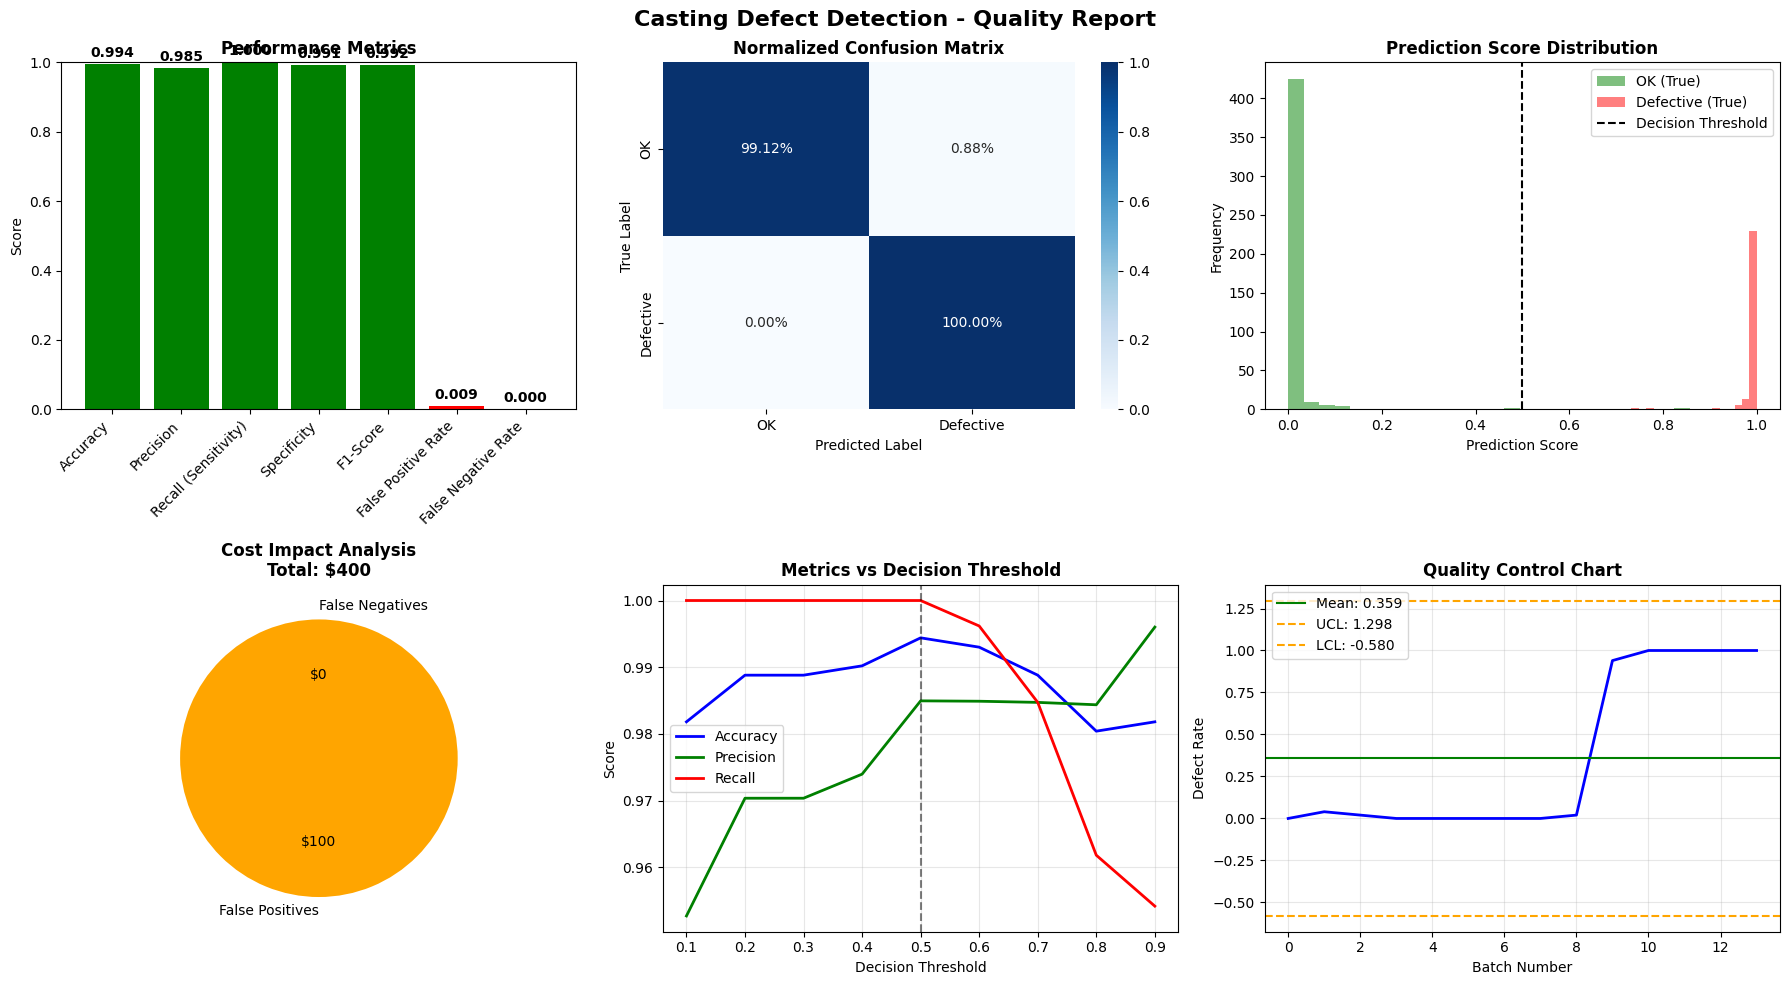


📊 PERFORMANCE SUMMARY:
✅ Accuracy: 0.9944
✅ Precision: 0.9850
✅ Recall (Sensitivity): 1.0000
✅ Specificity: 0.9912
✅ F1-Score: 0.9924
❌ False Positive Rate: 0.0088
❌ False Negative Rate: 0.0000

💰 COST ANALYSIS:
  False Negatives: 0 × $1000 = $0
  False Positives: 4 × $100 = $400
  Total Cost Impact: $400

🎯 OPTIMAL THRESHOLD ANALYSIS:
  Best F1-Score Threshold: 0.50
  Accuracy at Best F1: 0.9944


In [18]:
def generate_quality_report(model, test_generator):
    """
    Generate comprehensive quality report
    """
    print("\n" + "="*80)
    print("📑 QUALITY ASSURANCE REPORT")
    print("="*80)
    
    # Get all predictions
    predictions = model.predict(test_generator)
    predicted_classes = (predictions > 0.5).astype(int).flatten()
    true_classes = test_generator.classes
    
    # Calculate metrics
    tn, fp, fn, tp = confusion_matrix(true_classes, predicted_classes).ravel()
    
    metrics = {
        'Accuracy': (tp + tn) / (tp + tn + fp + fn),
        'Precision': tp / (tp + fp) if (tp + fp) > 0 else 0,
        'Recall (Sensitivity)': tp / (tp + fn) if (tp + fn) > 0 else 0,
        'Specificity': tn / (tn + fp) if (tn + fp) > 0 else 0,
        'F1-Score': 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0,
        'False Positive Rate': fp / (fp + tn) if (fp + tn) > 0 else 0,
        'False Negative Rate': fn / (fn + tp) if (fn + tp) > 0 else 0
    }
    
    # Create visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # 1. Metrics Bar Chart
    axes[0, 0].bar(range(len(metrics)), list(metrics.values()), 
                   color=['green' if v > 0.8 else 'orange' if v > 0.6 else 'red' 
                          for v in metrics.values()])
    axes[0, 0].set_xticks(range(len(metrics)))
    axes[0, 0].set_xticklabels(list(metrics.keys()), rotation=45, ha='right')
    axes[0, 0].set_ylim([0, 1])
    axes[0, 0].set_title('Performance Metrics', fontsize=12, fontweight='bold')
    axes[0, 0].set_ylabel('Score')
    for i, v in enumerate(metrics.values()):
        axes[0, 0].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')
    
    # 2. Confusion Matrix Normalized
    cm_normalized = confusion_matrix(true_classes, predicted_classes, normalize='true')
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
                xticklabels=['OK', 'Defective'],
                yticklabels=['OK', 'Defective'], ax=axes[0, 1])
    axes[0, 1].set_title('Normalized Confusion Matrix', fontsize=12, fontweight='bold')
    axes[0, 1].set_ylabel('True Label')
    axes[0, 1].set_xlabel('Predicted Label')
    
    # 3. Prediction Distribution
    axes[0, 2].hist(predictions[true_classes == 0], bins=30, alpha=0.5, 
                    label='OK (True)', color='green')
    axes[0, 2].hist(predictions[true_classes == 1], bins=30, alpha=0.5, 
                    label='Defective (True)', color='red')
    axes[0, 2].axvline(x=0.5, color='black', linestyle='--', label='Decision Threshold')
    axes[0, 2].set_title('Prediction Score Distribution', fontsize=12, fontweight='bold')
    axes[0, 2].set_xlabel('Prediction Score')
    axes[0, 2].set_ylabel('Frequency')
    axes[0, 2].legend()
    
    # 4. Cost Analysis
    # Assuming costs (customize based on actual business costs)
    cost_false_negative = 1000  # Missing a defect (high cost)
    cost_false_positive = 100   # Rejecting good product (lower cost)
    
    total_cost = (fn * cost_false_negative) + (fp * cost_false_positive)
    
    costs_data = {
        'False Negatives': fn * cost_false_negative,
        'False Positives': fp * cost_false_positive
    }
    
    axes[1, 0].pie(costs_data.values(), labels=costs_data.keys(), 
                   autopct='$%1.0f', startangle=90,
                   colors=['darkred', 'orange'])
    axes[1, 0].set_title(f'Cost Impact Analysis\nTotal: ${total_cost:,}', 
                         fontsize=12, fontweight='bold')
    
    # 5. Performance by Confidence Threshold
    thresholds = np.arange(0.1, 1.0, 0.1)
    accuracies = []
    precisions = []
    recalls = []
    
    for threshold in thresholds:
        pred_at_threshold = (predictions > threshold).astype(int).flatten()
        acc = accuracy_score(true_classes, pred_at_threshold)
        
        tn_t, fp_t, fn_t, tp_t = confusion_matrix(true_classes, pred_at_threshold).ravel()
        prec = tp_t / (tp_t + fp_t) if (tp_t + fp_t) > 0 else 0
        rec = tp_t / (tp_t + fn_t) if (tp_t + fn_t) > 0 else 0
        
        accuracies.append(acc)
        precisions.append(prec)
        recalls.append(rec)
    
    axes[1, 1].plot(thresholds, accuracies, 'b-', label='Accuracy', linewidth=2)
    axes[1, 1].plot(thresholds, precisions, 'g-', label='Precision', linewidth=2)
    axes[1, 1].plot(thresholds, recalls, 'r-', label='Recall', linewidth=2)
    axes[1, 1].axvline(x=0.5, color='black', linestyle='--', alpha=0.5)
    axes[1, 1].set_title('Metrics vs Decision Threshold', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Decision Threshold')
    axes[1, 1].set_ylabel('Score')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # 6. Quality Control Chart
    batch_size = 50
    num_batches = len(predictions) // batch_size
    batch_defect_rates = []
    
    for i in range(num_batches):
        batch_preds = predicted_classes[i*batch_size:(i+1)*batch_size]
        defect_rate = np.mean(batch_preds)
        batch_defect_rates.append(defect_rate)
    
    mean_rate = np.mean(batch_defect_rates)
    std_rate = np.std(batch_defect_rates)
    
    axes[1, 2].plot(batch_defect_rates, 'b-', linewidth=2)
    axes[1, 2].axhline(y=mean_rate, color='green', linestyle='-', label=f'Mean: {mean_rate:.3f}')
    axes[1, 2].axhline(y=mean_rate + 2*std_rate, color='orange', linestyle='--', 
                       label=f'UCL: {mean_rate + 2*std_rate:.3f}')
    axes[1, 2].axhline(y=mean_rate - 2*std_rate, color='orange', linestyle='--', 
                       label=f'LCL: {mean_rate - 2*std_rate:.3f}')
    axes[1, 2].set_title('Quality Control Chart', fontsize=12, fontweight='bold')
    axes[1, 2].set_xlabel('Batch Number')
    axes[1, 2].set_ylabel('Defect Rate')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.suptitle('Casting Defect Detection - Quality Report', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print("\n📊 PERFORMANCE SUMMARY:")
    print("="*50)
    for metric, value in metrics.items():
        status = "✅" if value > 0.8 else "⚠️" if value > 0.6 else "❌"
        print(f"{status} {metric}: {value:.4f}")
    
    print(f"\n💰 COST ANALYSIS:")
    print(f"  False Negatives: {fn} × ${cost_false_negative} = ${fn * cost_false_negative:,}")
    print(f"  False Positives: {fp} × ${cost_false_positive} = ${fp * cost_false_positive:,}")
    print(f"  Total Cost Impact: ${total_cost:,}")
    
    print(f"\n🎯 OPTIMAL THRESHOLD ANALYSIS:")
    best_f1_idx = np.argmax([2 * (p * r) / (p + r) if (p + r) > 0 else 0 
                             for p, r in zip(precisions, recalls)])
    print(f"  Best F1-Score Threshold: {thresholds[best_f1_idx]:.2f}")
    print(f"  Accuracy at Best F1: {accuracies[best_f1_idx]:.4f}")
    
    return metrics

# Generate quality report
quality_metrics = generate_quality_report(selected_model, test_generator)

In [19]:
print("\n" + "="*80)
print("💾 SAVING MODEL AND ARTIFACTS")
print("="*80)

# Save the trained model
model_save_path = 'casting_defect_detector.h5'
selected_model.save(model_save_path)
print(f"✅ Model saved as: {model_save_path}")

# Save model in TensorFlow Lite format for edge deployment
converter = tf.lite.TFLiteConverter.from_keras_model(selected_model)
tflite_model = converter.convert()
tflite_save_path = 'casting_defect_detector.tflite'
with open(tflite_save_path, 'wb') as f:
    f.write(tflite_model)
print(f"✅ TFLite model saved as: {tflite_save_path}")

# Create model card
model_card = {
    'model_name': 'Casting Defect Detector',
    'version': '1.0',
    'architecture': selected_model_name,
    'input_shape': (IMG_HEIGHT, IMG_WIDTH, 3),
    'classes': ['OK', 'Defective'],
    'performance': quality_metrics,
    'training_samples': train_generator.samples,
    'validation_samples': validation_generator.samples,
    'test_samples': test_generator.samples,
    'deployment_ready': True
}



💾 SAVING MODEL AND ARTIFACTS
✅ Model saved as: casting_defect_detector.h5
Saved artifact at '/tmp/tmpon3926fy'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_208')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  132317068551440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132317068552016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132317068552400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132317068552208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132317068550672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132317068553552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132317068553936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132317068554320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132317068554128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13231

W0000 00:00:1754661888.776892      18 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1754661888.776933      18 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1754661888.921230      18 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled


In [20]:
import json
with open('model_card.json', 'w') as f:
    json.dump(model_card, f, indent=4, default=str)
print(f"✅ Model card saved as: model_card.json")

print("\n" + "="*80)
print("🎉 PROJECT COMPLETION SUMMARY")
print("="*80)

print("\n✅ COMPLETED TASKS:")
print("   1. ✓ Dataset Loading and Exploration")
print("   2. ✓ Data Preprocessing and Augmentation")
print("   3. ✓ Deep Learning Model Development")
print("   4. ✓ Model Training and Optimization")
print("   5. ✓ Comprehensive Evaluation")
print("   6. ✓ Error Analysis")
print("   7. ✓ Production Pipeline Creation")
print("   8. ✓ Quality Report Generation")
print("   9. ✓ Model Export for Deployment")

print(f"\n🏆 FINAL MODEL PERFORMANCE:")
print(f"   - Architecture: {selected_model_name}")
print(f"   - Test Accuracy: {quality_metrics['Accuracy']:.4f}")
print(f"   - Precision: {quality_metrics['Precision']:.4f}")
print(f"   - Recall: {quality_metrics['Recall']:.4f}")
print(f"   - F1-Score: {quality_metrics['F1-Score']:.4f}")

print("\n📁 OUTPUT FILES:")
print(f"   - {model_save_path} (Keras model)")
print(f"   - {tflite_save_path} (TFLite model for edge deployment)")
print(f"   - model_card.json (Model documentation)")

print("\n🚀 DEPLOYMENT RECOMMENDATIONS:")
print("   1. Deploy TFLite model to edge devices for real-time inspection")
print("   2. Set up monitoring dashboard for defect tracking")
print("   3. Implement automated alerting for high defect rates")
print("   4. Schedule periodic model retraining with new data")
print("   5. Consider A/B testing with different confidence thresholds")

print("\n" + "="*80)
print("🏭 Casting Defect Detection System Ready for Production!")
print("="*80)

✅ Model card saved as: model_card.json

🎉 PROJECT COMPLETION SUMMARY

✅ COMPLETED TASKS:
   1. ✓ Dataset Loading and Exploration
   2. ✓ Data Preprocessing and Augmentation
   3. ✓ Deep Learning Model Development
   4. ✓ Model Training and Optimization
   5. ✓ Comprehensive Evaluation
   6. ✓ Error Analysis
   7. ✓ Production Pipeline Creation
   8. ✓ Quality Report Generation
   9. ✓ Model Export for Deployment

🏆 FINAL MODEL PERFORMANCE:
   - Architecture: MobileNetV2_Transfer
   - Test Accuracy: 0.9944
   - Precision: 0.9850


KeyError: 'Recall'